In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import random
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import datetime
import sys
import sklearn
from torch.autograd import Function
import torch.nn.functional as F
from sklearn.metrics import f1_score
import os
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from torchvision import datasets

In [2]:
batch_size = 16
input_size = (256, 128)
aspect_ratio = [2, 1]
is_vit = False
if(torch.cuda.is_available()):
  device=torch.device('cuda')
  print("GPU")
else:
  device=torch.device('cpu')
  print('CPU')

GPU


In [3]:
def progress_bar(start, i, training_batch_count):
    elapsed_time = (datetime.datetime.now() - start).seconds // 60
    sys.stdout.write('\r')
    sys.stdout.write("Validating: [%-50s] %d%% || ETA: %d minutes"
                     % ('=' * int(50 * (i + 1) / training_batch_count), int(100 * (i + 1) / training_batch_count),
                        (elapsed_time / (i+1)) * (training_batch_count - i)))
    sys.stdout.flush()
    
def show_image_grid(images, count, title=''):
    _, axs = plt.subplots(int(1+(count-1)/4), 4, figsize=(count*4, 12))
    axs = axs.flatten()
    for img, ax in zip(images, axs):
        if img.mode == 'RGB':
            ax.imshow(img, vmin=0, vmax=255)
        else:
            ax.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.title(title)
    plt.show()
    
def resize_to_square(image):
    wpercent = (input_size[0] / float(image.size[0]))
    hsize = int((float(image.size[1]) * float(wpercent)))
    image = image.resize((input_size[0], hsize), Image.Resampling.LANCZOS)
    height_to_pad = int((input_size[1]-image.size[1])/2)
    image = transforms.Pad((0, height_to_pad, 0, height_to_pad))(image)
    image = image.resize(input_size)
    return image

def resize_image_with_aspect(image):
    w, h = image.size
    cut_h = h - aspect_ratio[1] * w / aspect_ratio[0]
    image = image.crop((0, cut_h / 2, w, h-(cut_h/2)))
    image = image.resize(input_size)
    return image

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.43335001, 0.43360192, 0.42602362), (0.28486016, 0.28320433, 0.28699529)),
])
flipTransform = transforms.RandomHorizontalFlip(p=1)
zoomTransform = transforms.RandomResizedCrop(input_size[:: -1], scale=(0.7, 1))
colorTransform = transforms.ColorJitter(brightness=(0.65, 0.9), contrast=(1.1, 1.35))

In [5]:
def generate_batches(df, train=True, validation=False):
    if train:
        labels = df['has_under_extrusion'].tolist()
    printers = df['printer_id'].unique().tolist()
    printer_domain_map = {printer_id: idx for idx, printer_id in enumerate(printers)}
    domains = [printer_domain_map[domain] for domain in df['printer_id'].tolist()]
    prints = df['print_id'].unique().tolist()
    print_domain_map = {print_id: idx for idx, print_id in enumerate(prints)}
    print_jobs = [print_domain_map[print] for print in df['print_id'].tolist()]
        
    image_paths = df['img_path'].tolist()
    current = 0
    while current < len(df):
        batch_images, batch_domains, batch_labels, batch_paths, batch_prints = [], [], [], [], []
        batch_idx = 0
        reserve_images, reserve_domains, reserve_labels, reserve_prints = [], [], [], []
        
        while batch_idx < batch_size:
            if current + batch_idx >= len(df):
                break
            
            image_path = image_paths[current + batch_idx]
            domain = domains[current + batch_idx]
            print_job = print_jobs[current + batch_idx]
            image_path = image_path.split('/')[-1]
            filename = '/home/shravandinakaran/data/'+image_path
            image = Image.open(filename)
            if is_vit:
                image = resize_to_square(image)
            else:
                image = resize_image_with_aspect(image)
            if train:
                label = labels[current + batch_idx]
                batch_labels.append(label)
            batch_domains.append(domain)
            batch_prints.append(print_job)
            batch_images.append(transform(image))
            batch_paths.append(image_path)
            batch_idx += 1
        current += batch_size
        if train:
            yield batch_images, np.array(batch_labels), np.array(batch_domains), np.array(batch_prints)
        else:
            yield batch_images, batch_paths

In [6]:
train_df = pd.read_csv('/home/shravandinakaran/data/train_.csv')
test_df = pd.read_csv('/home/shravandinakaran/data/test_.csv')
val_df = pd.read_csv('/home/shravandinakaran/data/val_.csv')
test_df = test_df.append(val_df)
rows = train_df.loc[train_df['print_id'].isin([1678419624, 1678445757, 1679265796, 1679221334, 1678589738])]
test_df = test_df.append(rows, ignore_index=True)
train_df.drop(rows.index, inplace=True)
print(len(test_df), len(train_df))
num_domains_train = len(train_df['printer_id'].unique().tolist())
num_domains_test = len(test_df['printer_id'].unique().tolist())
num_domains_total = len(set(train_df['printer_id'].unique().tolist() + test_df['printer_id'].unique().tolist()))

35900 40713


In [7]:
source_df = pd.read_csv('/home/shravandinakaran/data/source.csv')
target_df = pd.read_csv('/home/shravandinakaran/data/target.csv')
print(len(source_df), len(target_df))

30162 30693


In [8]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [9]:
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

In [10]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.resnet = resnet = models.resnet18()
        self.resnet.fc = Identity()

        self.LeNet = nn.Sequential()
        self.LeNet.add_module('f_conv1', nn.Conv2d(3, 64, kernel_size=5))
        self.LeNet.add_module('f_bn1', nn.BatchNorm2d(64))
        self.LeNet.add_module('f_pool1', nn.MaxPool2d(2))
        self.LeNet.add_module('f_relu1', nn.ReLU(True))
        self.LeNet.add_module('f_conv2', nn.Conv2d(64, 128, kernel_size=5))
        self.LeNet.add_module('f_bn2', nn.BatchNorm2d(128))
        self.LeNet.add_module('f_pool2', nn.MaxPool2d(2))
        self.LeNet.add_module('f_relu2', nn.ReLU(True))
        self.LeNet.add_module('f_conv3', nn.Conv2d(128, 128, kernel_size=5))
        self.LeNet.add_module('f_bn3', nn.BatchNorm2d(128))
        self.LeNet.add_module('f_pool3', nn.MaxPool2d(2))
        self.LeNet.add_module('f_relu3', nn.ReLU(True))
        self.LeNet.add_module('f_conv4', nn.Conv2d(128, 50, kernel_size=5))
        self.LeNet.add_module('f_bn4', nn.BatchNorm2d(50))
        self.LeNet.add_module('f_drop1', nn.Dropout2d())
        self.LeNet.add_module('f_pool4', nn.MaxPool2d(2))
        self.LeNet.add_module('f_relu4', nn.ReLU(True))

        self.class_classifier = nn.Sequential()
        self.class_classifier.add_module('c_fc1', nn.Linear(512, 100))
        self.class_classifier.add_module('c_bn1', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu1', nn.ReLU(True))
        self.class_classifier.add_module('c_drop1', nn.Dropout())
        self.class_classifier.add_module('c_fc2', nn.Linear(100, 100))
        self.class_classifier.add_module('c_bn2', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu2', nn.ReLU(True))
        self.class_classifier.add_module('c_fc3', nn.Linear(100, 2))
        self.class_classifier.add_module('c_softmax', nn.LogSoftmax(dim=1))

        self.domain_classifier = nn.Sequential()
        self.domain_classifier.add_module('d_fc1', nn.Linear(512, 100))
        self.domain_classifier.add_module('d_bn1', nn.BatchNorm1d(100))
        self.domain_classifier.add_module('d_relu1', nn.ReLU(True))
        self.domain_classifier.add_module('d_fc2', nn.Linear(100, 2))
        self.domain_classifier.add_module('d_softmax', nn.LogSoftmax(dim=1))

    def forward(self, input_data, alpha):
        # input_data = input_data.expand(input_data.data.shape[0], 3, 32, 32)
        # feature = self.LeNet(input_data)
        feature = self.resnet(input_data)
        feature = feature.view(-1, 512)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.class_classifier(feature)
        domain_output = self.domain_classifier(reverse_feature)

        return class_output, domain_output


In [11]:
model = Model()
model = model.to(device)
loss_class = torch.nn.NLLLoss()
loss_domain = torch.nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
n_epochs = 20
print_count = 5
train_loss = []
for epoch in range(n_epochs):
    source_df = source_df.sample(frac=1).reset_index(drop=True)
    source_generator = generate_batches(source_df)
    target_generator = generate_batches(target_df)
    
    len_dataloader = min(len(source_df) // batch_size, len(target_df) // batch_size) - 1
    running_loss, correct, domain_correct, total, current_step = 0.0, 0, 0, 0, 0
    total_step_loss, step_loss, domain_step_loss, domain_running_loss = 0.0, 0.0, 0.0, 0.0
    print(f'\nEpoch {epoch+1}')
    model.train()
    i = -1
    while i < len_dataloader:
        i += 1
        images, labels, _, _ = next(source_generator)
        p = float(i + epoch * len_dataloader) / n_epochs / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1
        optimizer.zero_grad()
        
        images = torch.stack(images, dim=0, out=None).to(device)
        class_label = torch.from_numpy(labels).to(device)
        class_domain = torch.zeros(batch_size).long().to(device)
        
        class_output, domain_output = model(images, alpha)
        
        err_s_label = loss_class(class_output, class_label)
        err_s_domain = loss_domain(domain_output, class_domain)
        
        _, pred = torch.max(class_output, dim=1)
        correct += torch.sum(pred==class_label).item()
        total += class_label.size(0)
        
        
        images, labels, _, _ = next(target_generator)
        images = torch.stack(images, dim=0, out=None).to(device)
        class_domain = torch.ones(batch_size).long().to(device)
        
        class_output, domain_output = model(images, alpha)

        err_t_domain = loss_domain(domain_output, class_domain)

        err = err_t_domain + err_s_domain + err_s_label
        err.backward()
        optimizer.step()
        
        running_loss += err_s_label.item()
        domain_running_loss += err_s_domain.item() + err_t_domain.item()
        step_loss += err_s_label.item()
        domain_step_loss += err_s_domain.item() + err_t_domain.item()
        
        
        current_step += 1
        if i % (1 + len_dataloader // print_count) == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Classification Loss: {:.4f}, Domain Loss: {:.4f}, Accuracy: {:.4f}' 
                   .format(epoch+1, n_epochs, i, len_dataloader, step_loss / current_step, domain_step_loss / current_step, correct / total))
            step_loss = 0.0
            domain_step_loss = 0.0   
            current_step = 0.0

    train_loss.append(running_loss/len_dataloader)
    print(f'\ntrain-loss: {running_loss/len_dataloader:.4f}, domain-loss: {domain_running_loss/len_dataloader:.4f}, train-acc: {(100 * correct/total):.4f}')
    # scheduler.step()
    
    if epoch % 1 == 0:
        test_loss = []
        f1_scores = []
        total_step = len(target_df) / batch_size
        target_df = target_df.sample(frac=1).reset_index(drop=True)
        generator = generate_batches(target_df)
        running_loss, correct, total, current_step, current_idx = 0.0, 0, 0, 0, 0
        model.eval()
        for images, labels, _, _ in generator:
            images = torch.stack(images, dim=0, out=None).to(device)
            labels = torch.from_numpy(labels).to(device)

            outputs, _ = model(images, alpha)
            err_s_label = loss_class(outputs, labels)
            running_loss += err_s_label.item()

            _, pred = torch.max(outputs, dim=1)
            correct += torch.sum(pred==labels).item()    
            total += labels.size(0)
            
            current_step += 1
            if current_step % (1 + total_step // print_count) == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Classification Loss: {:.4f}' 
                       .format(epoch+1, n_epochs, current_step, total_step, running_loss / current_step))
            
        test_loss.append(running_loss/total_step)
        print(f'\ntest-loss: {np.mean(test_loss):.4f}, test-acc: {(100 * correct/total):.4f}')
    


Epoch 1
Epoch [1/20], Step [0/1884], Classification Loss: 0.9409, Domain Loss: 1.5245, Accuracy: 0.4375
Epoch [1/20], Step [377/1884], Classification Loss: 0.0755, Domain Loss: 1.3593, Accuracy: 0.9755
Epoch [1/20], Step [754/1884], Classification Loss: 0.0292, Domain Loss: 1.3593, Accuracy: 0.9839
Epoch [1/20], Step [1131/1884], Classification Loss: 0.0287, Domain Loss: 1.3458, Accuracy: 0.9865
Epoch [1/20], Step [1508/1884], Classification Loss: 0.0217, Domain Loss: 1.3342, Accuracy: 0.9883

train-loss: 0.0345, domain-loss: 1.3442, train-acc: 98.9755
Epoch [1/20], Step [384/1918.3125], Classification Loss: 1.0161
Epoch [1/20], Step [768/1918.3125], Classification Loss: 1.9981
Epoch [1/20], Step [1152/1918.3125], Classification Loss: 3.0102
Epoch [1/20], Step [1536/1918.3125], Classification Loss: 4.0058

test-loss: 5.0152, test-acc: 56.9446

Epoch 2
Epoch [2/20], Step [0/1884], Classification Loss: 0.0107, Domain Loss: 1.2927, Accuracy: 1.0000
Epoch [2/20], Step [377/1884], Classifi

In [101]:
images, labels, domains, print_jobs = next(train_generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 2, 4)

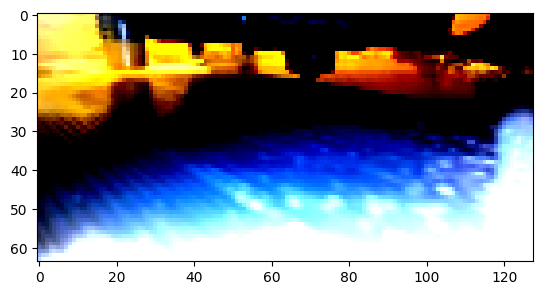

In [121]:
plt.imshow(images[14].permute(1, 2, 0))
labels[9], domains[9], print_jobs[9]

In [27]:
torch.save(model, 'LeNet3D_63_67.pth')